<a href="https://colab.research.google.com/github/jmoortgat/Hydrate/blob/main/Hydrate_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import xlrd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import matplotlib.pyplot as plt

# Change some default figure properties to make them prettier:
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3

# ML Algorithms for Bulk Sediment Density and P-Wave Velocity Predictions

## User Input

Pick test data:
1.   WR313-G
2.   WR313-H

In [ ]:
test_data = 2

Pick variable to predict


1.   $\rho_b$
2.   $V_p$



In [ ]:
variable = 1

For $V_p$, pick case:


1.   Case 1
2.   Case 2



In [ ]:
case = 1

## Metrics

Functions to compute R_2, MAPE and downscale the predicted outputs

In [ ]:
def R_2(y_pred, y_true):
    corr_matrix = np.corrcoef(y_pred, y_true)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return (R_sq)

def MAPE(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs(y_pred - y_true)/np.abs(y_true))*100

def smooth(y, box_pts): #moving average filter for downsampling the outputs
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## Data acquisition

Read in training data:

In [ ]:
if variable == 1:
  df = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Training_Data_Rhob.csv")
else:
  if case ==1 :
    df = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Training_Data_Vp_Case1.csv")
  else:
    df = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Training_Data_Vp_Case2.csv")

and validation data:

In [ ]:
if variable == 1:
  y_var = 'RHOB'
else:
  y_var = 'Vp'

if variable == 1:
  if test_data==1:
    vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-G_Rhob.csv")
  else:
    vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-H_Rhob.csv")
else:
  if test_data==1:
    if case == 1:
      vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-G_Vp_Case1.csv")
    else:
      vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-G_Vp_Case2.csv")
  else:
    if case == 1:
      vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-H_Vp_Case1.csv")
    else:
      vs = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/WR313-H_Vp_Case2.csv")

depth_label = 'Depth (mbsf)'

Show header of variable names and a few values:

In [ ]:
df.head()

,Depth (mbsf),GR,Vp,RES,RHOB
0,513.0952,71.54287,1667.604,0.309480,1.969237
1,512.9428,76.18578,1673.023,0.320824,1.969107
2,513.8572,71.61407,1655.831,0.392803,1.992180
3,162.8800,86.89611,1549.503,0.458114,1.846918
4,514.0096,72.73511,1659.237,0.459769,1.991311


## Training and Validation Data

Define training and validation data:

In [ ]:
#Define dependent variable
Y = df[y_var].values
Y_vs = vs[y_var].values

#Define independent variables
X = df.drop(labels=[depth_label,y_var], axis=1)
X_vs = vs.drop(labels=[depth_label,y_var], axis=1)


#Split data into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

In [ ]:
np.shape(X)

(34341, 3)

## Normalizing the inputs

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_vs_scaled = scaler.transform(X_vs)

## ML Models

### Linear regression Normalized

Train model:

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, Y_train)

LinearRegression()

Predictions:

In [ ]:
prediction_train = model.predict(X_train_scaled)
prediction_test = model.predict(X_test_scaled)
prediction_vs = model.predict(X_vs_scaled)
prediction_vs_downsampled = smooth(prediction_vs, 7)

R_2 and MAPE

In [ ]:
print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs, Y_vs),2))
print("Validation R_2 sampled:",round(R_2(prediction_vs_downsampled, Y_vs),2))

print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs, Y_vs),2))
print("Validation MAPE sampled:",round(MAPE(prediction_vs_downsampled, Y_vs),2))

Train R_2: 0.31
Test R_2: 0.31
Validation R_2: 0.17
Validation R_2 sampled: 0.38
Train MAPE: 5.18
Test MAPE: 5.12
Validation MAPE: 5.23
Validation MAPE sampled: 5.21


#### Figures

Plot prediction versus measurements, which should fall onto 1:1 line if predictions are good:

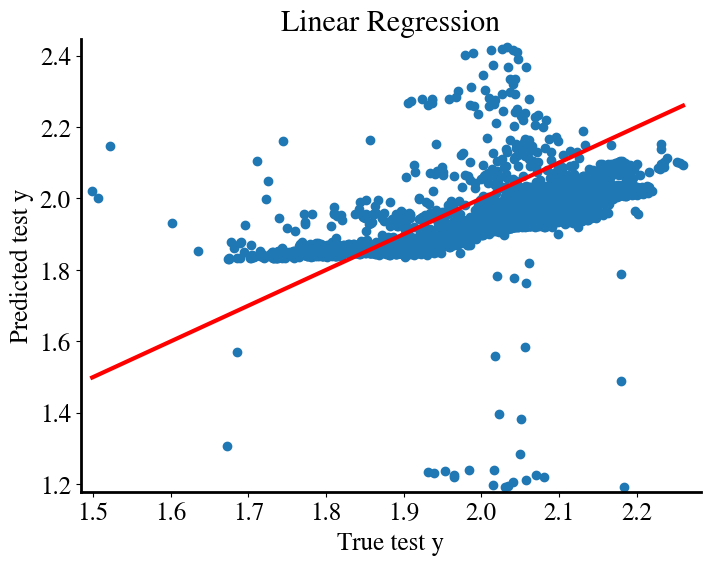

In [ ]:
plt.scatter(Y_vs,prediction_vs_downsampled)
xyrange = np.linspace(np.min(Y_vs), np.max(Y_vs),10)
plt.plot(xyrange,xyrange ,'r')

plt.xlim([0.99*np.min(Y_vs[7:-7]), 1.01*np.max(Y_vs[7:-7])])
plt.ylim([0.99*np.min(prediction_vs_downsampled[7:-7]), 1.01*np.max(prediction_vs_downsampled[7:-7])])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')
plt.title('Linear Regression');

Plot prediction versus depth and true data versus depth:

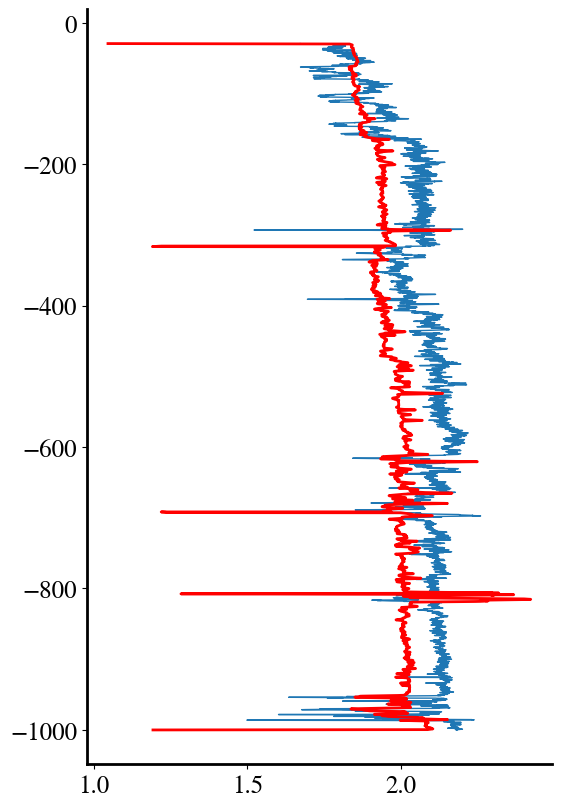

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,10))
plt.plot(Y_vs,-depth,linewidth=1) ;
plt.plot(prediction_vs_downsampled,-depth,'r-',linewidth=2) ;


### Polynomial Regression (4th order)

In [ ]:
model = PolynomialFeatures(degree=4)
X_poly = model.fit_transform(X_train)
X_poly_test = model.fit_transform(X_test)
lin_reg = LinearRegression();
lin_reg.fit(X_poly, Y_train)

print("Number of fitting parameters:", np.shape(X_poly)[1])

Number of fitting parameters: 35


In [ ]:
truncate_poly_prediction = True 

Validation data:

In [ ]:
prediction_train = lin_reg.predict(X_poly)
prediction_test = lin_reg.predict(X_poly_test)
X_val = model.fit_transform(X_vs)
prediction_vs = lin_reg.predict(X_val)

if truncate_poly_prediction:
  print("Minimum and maximum of training results:", np.min(prediction_train), np.max(prediction_train), " and test predictions:", np.min(prediction_test), np.max(prediction_test))
  print("Minimum and maximum of measurements:", np.min(Y_vs), np.max(Y_vs), " versus predictions:", np.min(prediction_vs), np.max(prediction_vs))

  #y_min = np.min([np.min(prediction_train), np.min(prediction_test)])
  #y_max = np.min([np.max(prediction_train), np.max(prediction_test)])
  # Changed after Vs Case 1, validation hole 2
  y_min = np.min(prediction_train)
  y_max = np.max(prediction_train)
  prediction_vs[prediction_vs<y_min] = y_min
  prediction_vs[prediction_vs>y_max] = y_max
  prediction_test[prediction_test<y_min] = y_min
  prediction_test[prediction_test>y_max] = y_max

prediction_vs_downsampled = smooth(prediction_vs, 7)

Minimum and maximum of training results: 1.4095444174747875 3.0011959662424097  and test predictions: 1.2520047129028313 2.687514843746122
Minimum and maximum of measurements: 1.498655 2.259801  versus predictions: -19902.37683389299 2.863193770005683


R2 Score and MAPE


In [ ]:
print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs_downsampled[7:-7], Y_vs[7:-7]),2))
print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs_downsampled[7:-7], Y_vs[7:-7]),2))

Train R_2: 0.62
Test R_2: 0.6
Validation R_2: 0.71
Train MAPE: 3.54
Test MAPE: 3.48
Validation MAPE: 2.05


#### Figures

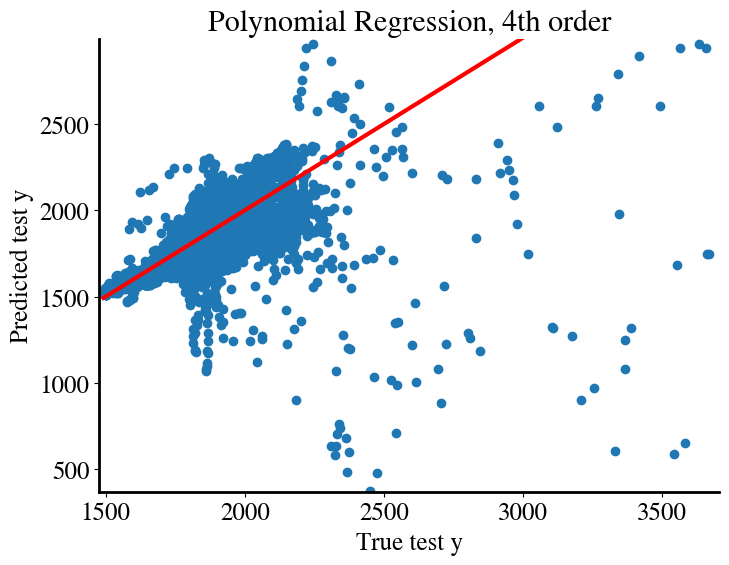

In [ ]:
plt.scatter(Y_vs[7:-7],prediction_vs_downsampled[7:-7])
xyrange = np.linspace(np.min(Y_vs), np.max(Y_vs),10)
plt.plot(xyrange,xyrange ,'r')

plt.xlim([0.99*np.min(Y_vs[7:-7]), 1.01*np.max(Y_vs[7:-7])])
plt.ylim([0.99*np.min(prediction_vs_downsampled[7:-7]), 1.01*np.max(prediction_vs_downsampled[7:-7])])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')
plt.title('Polynomial Regression, 4th order');

Plot predictions and true data vs depth:

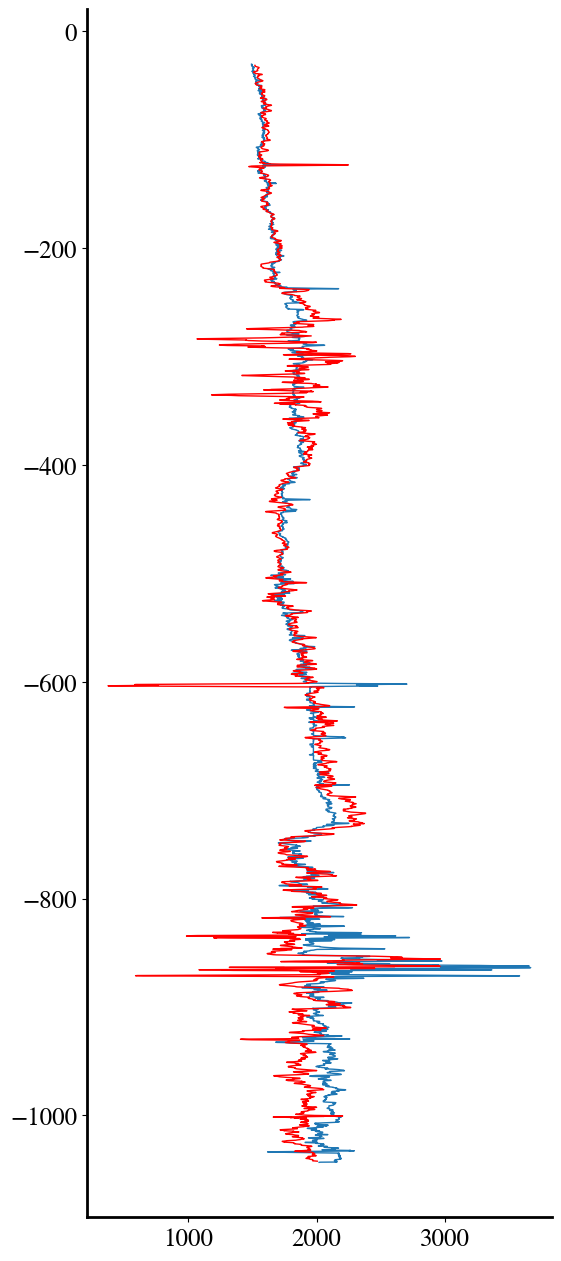

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,16))
plt.plot(Y_vs,-depth,linewidth=1) 
plt.plot(prediction_vs_downsampled[7:-7],-depth[7:-7],'r-',linewidth=1) ;

### Polynomial Regression with Ridge Regularization

In [ ]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_train_scaled)
X_poly_test = poly.fit_transform(X_test_scaled)
X_poly_vs = poly.fit_transform(X_vs_scaled)

if variable == 2 and case == 2: # 
  linRidge = Ridge(alpha = 0.001, max_iter=100000).fit(X_poly, Y_train)
else:
  linRidge = Ridge(alpha = 0.01, max_iter=100000).fit(X_poly, Y_train)
prediction_train = linRidge.predict(X_poly)
prediction_test = linRidge.predict(X_poly_test)
prediction_vs = linRidge.predict(X_poly_vs)


truncate_poly_prediction = True 
if truncate_poly_prediction:
  print("Minimum and maximum of training results:", np.min(prediction_train), np.max(prediction_train), " and test predictions:", np.min(prediction_test), np.max(prediction_test))
  print("Minimum and maximum of measurements:", np.min(Y_vs), np.max(Y_vs), " versus predictions:", np.min(prediction_vs), np.max(prediction_vs))

  y_min = np.min([np.min(prediction_train), np.min(prediction_test)])
  y_max = np.min([np.max(prediction_train), np.max(prediction_test)])
  # Changed after Vs Case 2, validation hole 1
  #y_min = np.min(prediction_train)
  #y_max = np.max(prediction_train)
  prediction_vs[prediction_vs<y_min] = y_min
  prediction_vs[prediction_vs>y_max] = y_max
  #prediction_test[prediction_test<y_min] = y_min
  #prediction_test[prediction_test>y_max] = y_max


prediction_vs_downsampled = smooth(prediction_vs, 7)

Minimum and maximum of training results: 1.6727585360520834 2.9839510327442422  and test predictions: 1.6740934647479506 2.3365989946349126
Minimum and maximum of measurements: 1.498655 2.259801  versus predictions: -436.85787085041324 5.886400522335361


R2 Score and MAPE

In [ ]:
print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs_downsampled[7:-7], Y_vs[7:-7]),2))
print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs_downsampled[7:-7], Y_vs[7:-7]),2))

Train R_2: 0.57
Test R_2: 0.57
Validation R_2: 0.75
Train MAPE: 3.86
Test MAPE: 3.8
Validation MAPE: 1.76


#### Figures

Plot y predicted versus y data, so should fall close to one-to-one linear line if the fit is good:

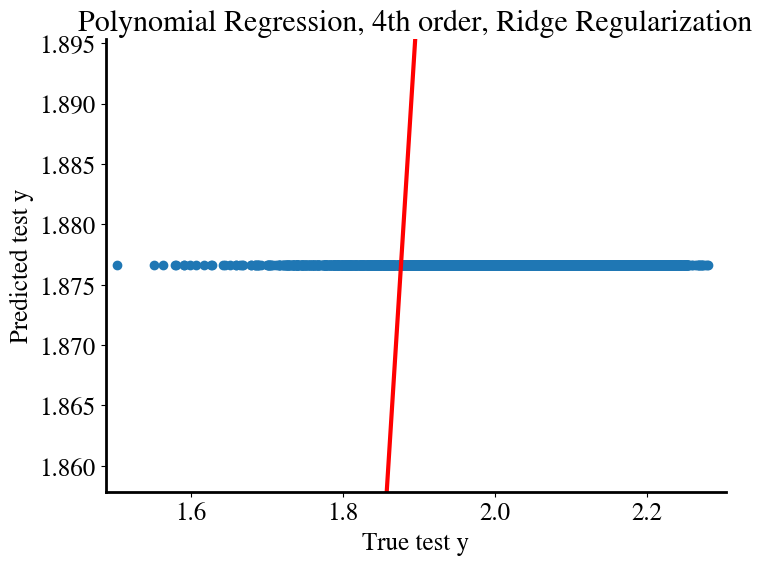

In [ ]:
plt.scatter(Y_vs[7:-7],prediction_vs_downsampled[7:-7])
xyrange = np.linspace(np.min(Y_vs[7:-7]), np.max(Y_vs[7:-7]),10)
plt.plot(xyrange,xyrange ,'r')

plt.xlim([0.99*np.min(Y_vs[7:-7]), 1.01*np.max(Y_vs[7:-7])])
plt.ylim([0.99*np.min(prediction_vs_downsampled[7:-7]), 1.01*np.max(prediction_vs_downsampled[7:-7])])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')
plt.title('Polynomial Regression, 4th order, Ridge Regularization');

Plot prediction and true data vs depth

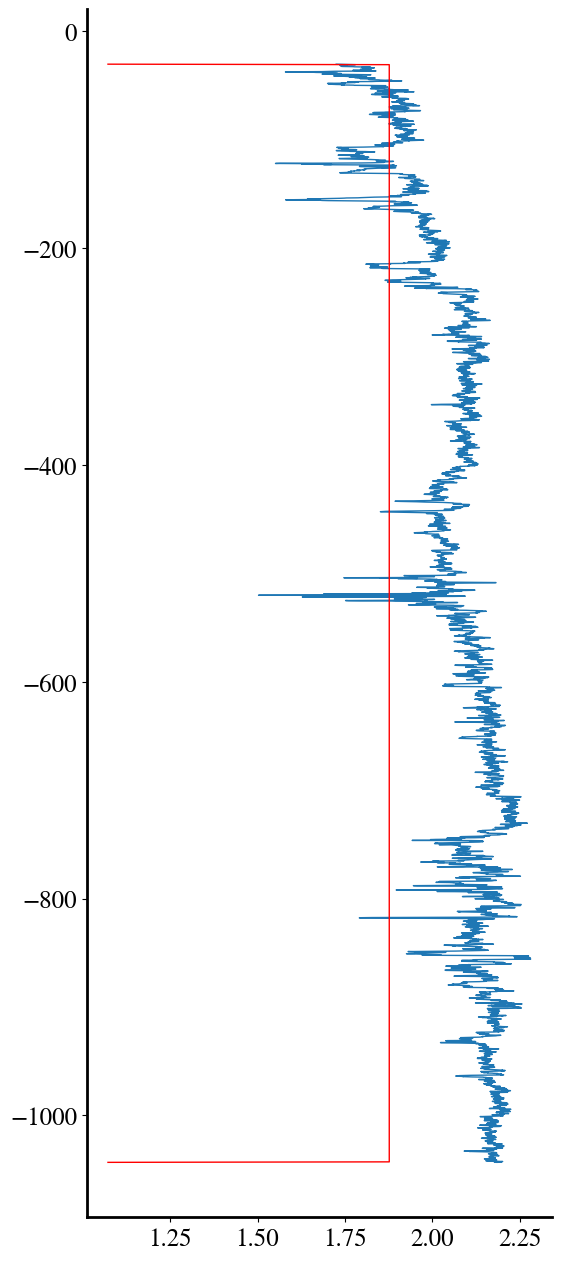

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,16))
plt.plot(Y_vs,-depth,linewidth=1) 
plt.plot(prediction_vs_downsampled,-depth,'r-',linewidth=1) ;

### K-Nearest Neighbors

In [ ]:
model = KNeighborsRegressor(n_neighbors=7, weights='distance')
model.fit(X_train_scaled, Y_train)

prediction_train = model.predict(X_train_scaled)
prediction_test = model.predict(X_test_scaled)
prediction_vs = model.predict(X_vs_scaled)
prediction_vs_downsampled = smooth(prediction_vs, 7)

print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs_downsampled, Y_vs),2))

print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs_downsampled,Y_vs),2))

Train R_2: 1.0
Test R_2: 0.76
Validation R_2: 0.7
Train MAPE: 0.0
Test MAPE: 2.55
Validation MAPE: 2.02


#### Figures

Plot y predicted versus y data, so should fall close to one-to-one linear line if the fit is good:

Text(0.5, 1.0, 'k-NN')

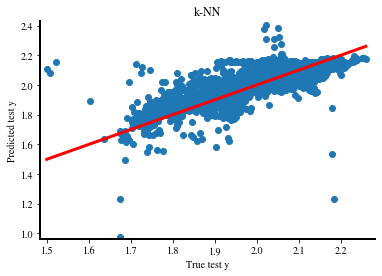

In [ ]:
plt.scatter(Y_vs,prediction_vs_downsampled)
xyrange = np.linspace(np.min(Y_vs), np.max(Y_vs),10)
plt.plot(xyrange,xyrange ,'r')

plt.xlim([0.99*np.min(Y_vs), 1.01*np.max(Y_vs)])
plt.ylim([0.99*np.min(prediction_vs_downsampled), 1.01*np.max(prediction_vs_downsampled)])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')

plt.title('k-NN')

Plot prediction and true data vs depth

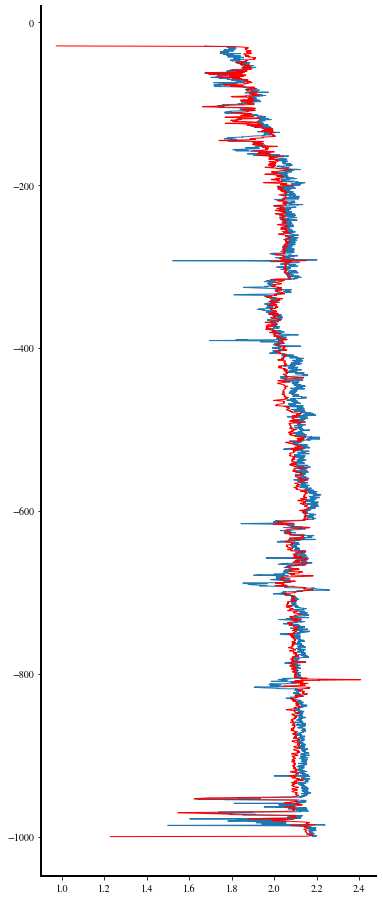

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,16))
plt.plot(Y_vs,-depth,linewidth=1) 
plt.plot(prediction_vs_downsampled,-depth,'r-',linewidth=1) ;

### Perceptron 

In [ ]:
if variable ==1:
  act_func = 'tanh'
else:
  act_func = 'relu'

model = MLPRegressor(hidden_layer_sizes=2, activation=act_func, batch_size='auto', learning_rate='constant', learning_rate_init=0.01, solver='adam', max_iter=2000, random_state=40, momentum=0.2).fit(X_train_scaled, Y_train)

prediction_train = model.predict(X_train_scaled)
prediction_test = model.predict(X_test_scaled)
prediction_vs = model.predict(X_vs_scaled)
prediction_vs_downsampled = smooth(prediction_vs, 7)

print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs_downsampled, Y_vs),2))

print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs_downsampled,Y_vs),2))

Train R_2: 0.57
Test R_2: 0.58
Validation R_2: 0.75
Train MAPE: 3.9
Test MAPE: 3.84
Validation MAPE: 1.64


#### Figures

Plot y predicted versus y data, so should fall close to one-to-one linear line if the fit is good:

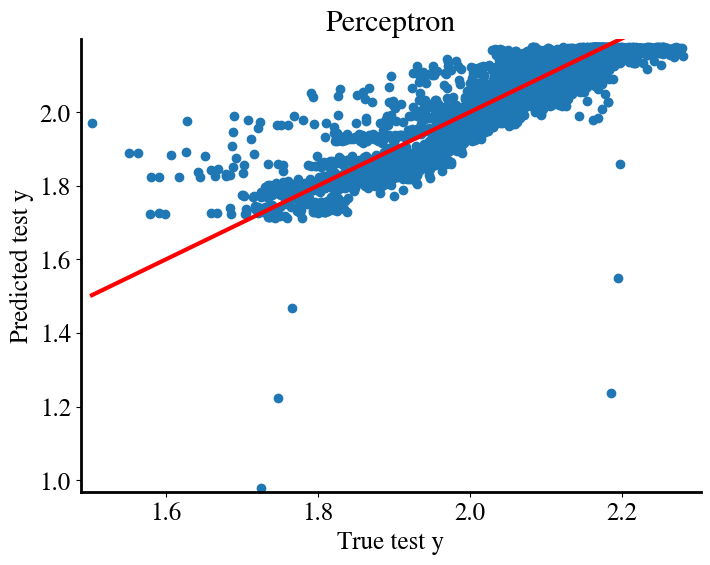

In [ ]:
plt.scatter(Y_vs,prediction_vs_downsampled)
xyrange = np.linspace(np.min(Y_vs), np.max(Y_vs),10)
plt.plot(xyrange,xyrange ,'r');

plt.xlim([0.99*np.min(Y_vs), 1.01*np.max(Y_vs)])
plt.ylim([0.99*np.min(prediction_vs_downsampled), 1.01*np.max(prediction_vs_downsampled)])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')
plt.title('Perceptron');

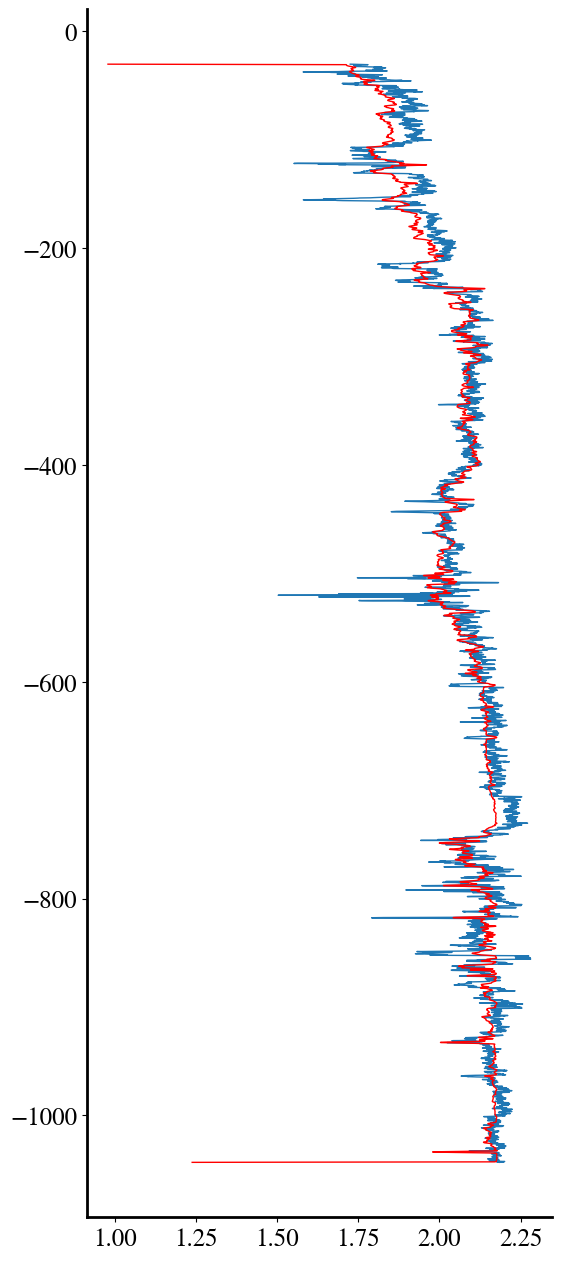

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,16))
plt.plot(Y_vs,-depth,linewidth=1) 
plt.plot(prediction_vs_downsampled,-depth,'r-',linewidth=1) ;

### Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators = 400, random_state=40, max_features="auto", min_samples_leaf = 1, max_depth = 15, min_samples_split = 2)
model.fit(X_train, Y_train)

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)
prediction_vs = model.predict(X_vs)
prediction_vs_downsampled = smooth(prediction_vs, 7)

print("Train R_2:",round(R_2(prediction_train, Y_train),2))
print("Test R_2:",round(R_2(prediction_test, Y_test),2))
print("Validation R_2:",round(R_2(prediction_vs_downsampled, Y_vs),2))
print("Train MAPE:",round(MAPE(prediction_train, Y_train),2))
print("Test MAPE:",round(MAPE(prediction_test,Y_test),2))
print("Validation MAPE:",round(MAPE(prediction_vs_downsampled,Y_vs),2))


Train R_2: 0.93
Test R_2: 0.81
Validation R_2: 0.68
Train MAPE: 1.51
Test MAPE: 2.3
Validation MAPE: 2.1


#### Figures

Plot y predicted versus y data, so should fall close to one-to-one linear line if the fit is good:

Text(0, 0.5, 'Random Forest')

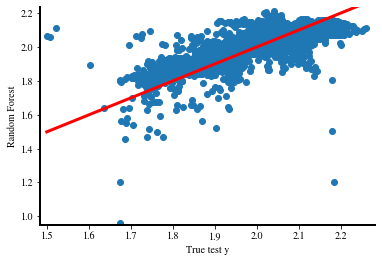

In [ ]:
plt.scatter(Y_vs,prediction_vs_downsampled)
xyrange = np.linspace(np.min(Y_vs), np.max(Y_vs),10)
plt.plot(xyrange,xyrange ,'r')

plt.xlim([0.99*np.min(Y_vs), 1.01*np.max(Y_vs)])
plt.ylim([0.99*np.min(prediction_vs_downsampled), 1.01*np.max(prediction_vs_downsampled)])

plt.xlabel('True test y')
plt.ylabel('Predicted test y')
plt.ylabel('Random Forest')

Plot vs depth:

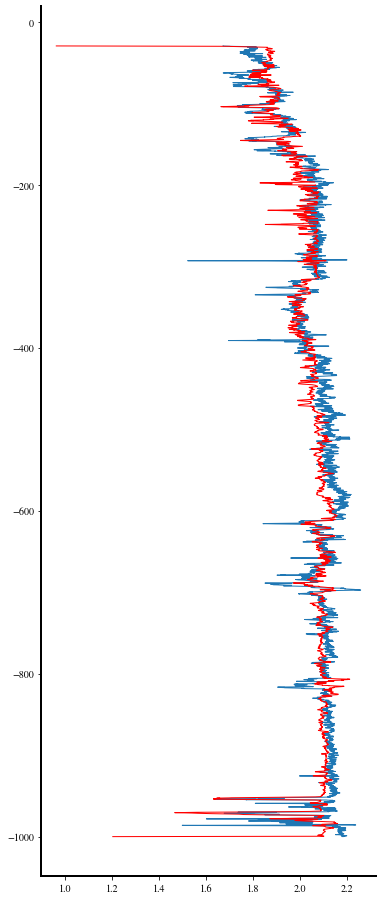

In [ ]:
depth = vs[depth_label].values
plt.figure(figsize=(6,16))
plt.plot(Y_vs,-depth,linewidth=1) 
plt.plot(prediction_vs_downsampled,-depth,'r-',linewidth=1) ;

## Summary statistics

### $\rho_b$, $\alpha=0.01$

Perceptron used activation function `tanh`.

 

R2

- | $\rho_b$ H1 |$\rho_b$ H2 | $\rho_b$ mean 
-----|-----|-----|----- 
Linear | 60 | 38 | 49
Poly |67|69 | 68
Poly - Ridge |**85**| **75** | **80**
Perceptron | **83** | **75** | **79**
KNN | 80 | 70 | 75
RF | 76 | 68 | 72



MAPE 

- | $\rho_b$ H1 |$\rho_b$ H2 | $\rho_b$ mean
-----|-----|-----|----- 
Linear | 5.12 | 5.21 | 5.17
Poly |2.63|2.06 | 2.35 
Poly - Ridge |**1.60**| **1.76** | **1.68**
Perceptron | **1.68** | **1.64** | **1.66**
KNN | 1.97 | 2.02 | 2.00
RF | 2.28 | 2.1 | 2.19


### $V_s$ Case 1, $\alpha=0.01$

Perceptron uses activation function `relu`

R2 

- | $V_s$ H1 |$V_s$ H2  | $V_s$ mean 
-----|-----|-----|----- 
Linear | 75 | 42 | 59
Poly |**81**|**70** | **76**
Poly - Ridge |**83**| 69 | **76**
Perceptron | 75 | 42 | 59
KNN |74 | **72** | 74
RF | 70 | 69 | 70


MAPE 

- | $V_s$ H1 |$V_s$ H2 | $V_s$ mean
-----|-----|-----|----- 
Linear | 6.13 | 5.24 | 6.44
Poly |**3.17**|3.41 | **3.29** 
Poly - Ridge |**2.87** | **3.10** | **2.99**
Perceptron | 6.16 | 5.28 | 5.72
KNN | 3.78 | **3.12** | 3.45
RF | 4.14 | 3.77 | 3.96


### $V_s$ Case 2, $\alpha = 0.001$



R2

- | $V_s$ H1 |$V_s$ H2 | $V_s$ mean 
-----|-----|-----|----- 
Linear | 54 | 51 | 53
Poly |-|- | -
Poly - Ridge |61| 52 | 57
Perceptron | 57 | 52 | 55
KNN |**65** | **63** | **64**
RF | **66** | **59** | **63**


MAPE 

- | $V_s$ H1 |$V_s$ H2 | $V_s$ mean
-----|-----|-----|----- 
Linear | 6.75 | 6.15 | 6.45
Poly |-|- | -
Poly - Ridge |4.94 | 4.94 | 4.94
Perceptron | 4.77 | 5.09 | 4.93
KNN | **4.64** | **4.16** | **4.40**
RF | **4.21** | **4.57** | **4.39**


All performance metrics in one table:


R2

$\rho_b$ | H1 |H2 |  mean | $V_s$ Case 1| H1 |H2 | mean  | $V_s$ Case 2| H1 |H2 | mean
-----|-----|-----|-----| -----|-----|-----|----- | -----|-----|-----|-----
Linear | 60 | 38 | 49 |  | 75 | 42 | 59 |  | 54 | 51 | 53
Poly |67|69 | 68| |**81**|**70** | **76** |  |-|- | -
Poly - Ridge |**85**| **75** | **80**|  |**83**| 69 | **76** |  |61| 52 | 57
Perceptron | **83** | **75** | **79**|  |75 | 42 | 59 |  | 57 | 52 | 55
KNN | 80 | 70 | 75| |74 | **72** | 74 |  |**65** | **63** | **64**
RF | 76 | 68 | 72|  | 70 | 69 | 70 |  | **66** | **59** | **63**



MAPE 

$\rho_b$ | H1 |H2 |  mean | $V_s$ Case 1| H1 |H2 | mean  | $V_s$ Case 2| H1 |H2 | mean
-----|-----|-----|-----| -----|-----|-----|----- | -----|-----|-----|-----
Linear | 5.12 | 5.21 | 5.17|  |6.13 | 5.24 | 6.44 |  | 6.75 | 6.15 | 6.45
Poly |2.63|2.06 | 2.35 | |**3.17**|3.41 | **3.29** |  |-|- | -
Poly - Ridge |**1.60**| **1.76** | **1.68**| |**2.87** | **3.10** | **2.99** | |4.94 | 4.94 | 4.94
Perceptron | **1.68** | **1.64** | **1.66**|  | 6.16 | 5.28 | 5.72 |  | 4.77 | 5.09 | 4.93
KNN | 1.97 | 2.02 | 2.00|  | 3.78 | **3.12** | 3.45 |  | **4.64** | **4.16** | **4.40**
RF | 2.28 | 2.1 | 2.19|  | 4.14 | 3.77 | 3.96 |  | **4.21** | **4.57** | **4.39**






## K-fold Cross Validation

K-fold cross validation computed using all the 22 wells (training + validation wells)

In [ ]:
Vp_Case_1 = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Vp_Case_1_K_fold_CV.csv")

Vp_Case_2 = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Vp_Case_2_K_fold_CV.csv")

Rhob_Case = pd.read_csv("https://raw.githubusercontent.com/jmoortgat/Hydrate/main/Rhob_Case_K_fold_CV.csv")



Defining X and Y for Vp_Case_1

In [ ]:
X_Vp_Case_1 = Vp_Case_1.drop(labels=['Depth (mbsf)','Vp'], axis=1)
Y_Vp_Case_1 = Vp_Case_1['Vp'].values

X_cv_Vp_Case_1, X_test_Vp_Case_1, Y_cv_Vp_Case_1, Y_test_Vp_Case_1 = train_test_split(X_Vp_Case_1, Y_Vp_Case_1, test_size=0.0000001, random_state=40)

Defining X and Y for Vp_Case_2

In [ ]:
X_Vp_Case_2 = Vp_Case_2.drop(labels=['Depth (mbsf)','Vp'], axis=1)
Y_Vp_Case_2 = Vp_Case_2['Vp'].values

X_cv_Vp_Case_2, X_test_Vp_Case_2, Y_cv_Vp_Case_2, Y_test_Vp_Case_2 = train_test_split(X_Vp_Case_2, Y_Vp_Case_2, test_size=0.0000001, random_state=40)

Defining X and Y for Rhob_Case

In [ ]:
X_Rhob_Case = Rhob_Case.drop(labels=['Depth (mbsf)','RHOB'], axis=1)
Y_Rhob_Case = Rhob_Case['RHOB'].values

X_cv_Rhob_Case, X_test_Rhob_Case, Y_cv_Rhob_Case, Y_test_Rhob_Case = train_test_split(X_Rhob_Case, Y_Rhob_Case, test_size=0.0000001, random_state=40)

In [ ]:
RF = RandomForestRegressor(n_estimators = 400, random_state=40, max_features="auto", min_samples_leaf = 1, max_depth = 15, min_samples_split = 2)
R2 = []
mape = []
for i in range(5,11):
    score = cross_val_predict(RF, X_Vp_Case_2, Y_Vp_Case_2, cv=i)
    R2.append(round(R_2(score, Y_Vp_Case_2),2))
    mape.append(round(MAPE(score, Y_Vp_Case_2),2))
print (R2)
print (mape)

[0.6, 0.65, 0.73, 0.7, 0.69, 0.69]
[4.14, 3.74, 3.4, 3.42, 3.44, 3.44]


In [ ]:
## add corresponding X_ Y_ to compute K-fold cross validation for each Case
KNN = KNeighborsRegressor(n_neighbors=7, weights='distance')
X_scaled = scaler.fit_transform(X_Rhob_Case)
score = cross_val_predict(KNN, X_scaled, Y_Rhob_Case, cv=10)
print(round(R_2(score, Y_Rhob_Case),2))
print(round(MAPE(score, Y_Rhob_Case),2))

0.76
2.86


In [ ]:
poly = PolynomialFeatures(degree=4)
X_scaled = scaler.fit_transform(X_Vp_Case_2)
X_poly = poly.fit_transform(X_scaled)

PR = Ridge(alpha = 0.1, max_iter=100000)
score = cross_val_predict(PR, X_poly, Y_Vp_Case_2, cv=5)
print(round(R_2(score, Y_Vp_Case_2),2))
print(round(MAPE(score, Y_Vp_Case_2),2))

0.77
3.17
